# 🛠️ Environment Setup
* **Seed Everything:** A crucial step to ensure reproducibility. By setting the seed for random, numpy, and python hashing, we ensure that the results can be replicated in future runs.

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import random
import warnings

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb

SEED = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("Block 1 completed ✔")
print("XGBoost version:", xgb.__version__)


Block 1 completed ✔
XGBoost version: 3.1.0


# 📂 Data Loading

In [2]:
# ====================================================
# BLOCK 2: Data Loading & Sanity Checks
# ====================================================

TRAIN_PATH = "/kaggle/input/playground-series-s5e12/train.csv"
TEST_PATH  = "/kaggle/input/playground-series-s5e12/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# 📉 Drift Analysis
Visualizing feature distribution shifts over time (or ID).
The plot above displays the rolling mean of `physical_activity_minutes_per_week` sorted by `id`.

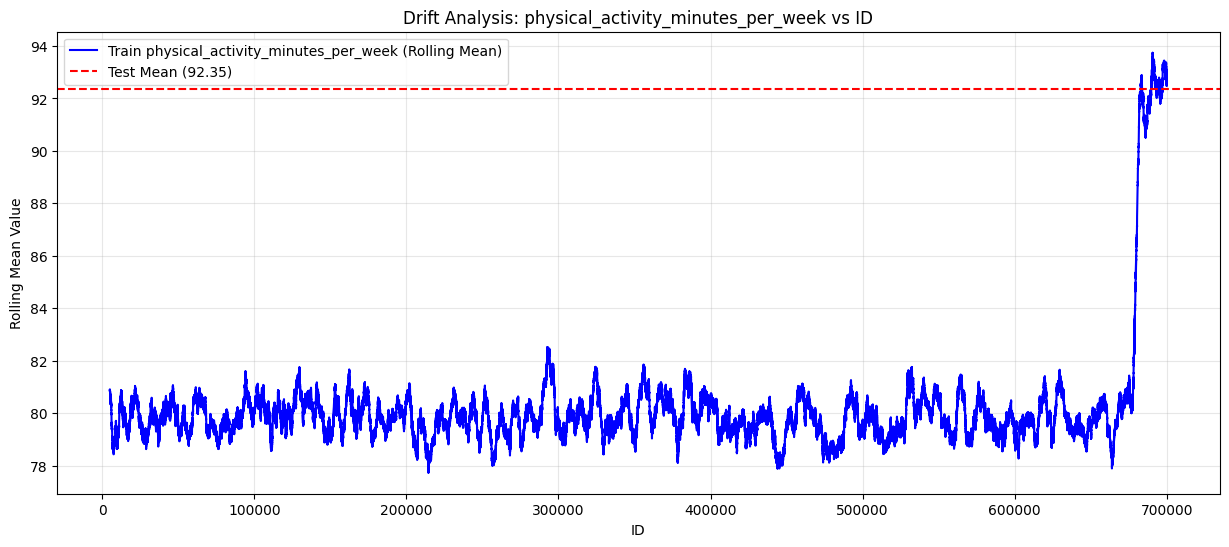

In [3]:
# ====================================================
# BLOCK 2.5: Drift Visualization
# ====================================================
import matplotlib.pyplot as plt
import seaborn as sns

feature = 'physical_activity_minutes_per_week'

plt.figure(figsize=(15, 6))

plt.plot(
    train_df['id'], 
    train_df[feature].rolling(window=5000).mean(), 
    label=f'Train {feature} (Rolling Mean)', 
    color='blue'
)

test_mean = test_df[feature].mean()
plt.axhline(y=test_mean, color='red', linestyle='--', label=f'Test Mean ({test_mean:.2f})')

plt.title(f'Drift Analysis: {feature} vs ID')
plt.xlabel('ID')
plt.ylabel('Rolling Mean Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 📏 Dataset Dimensions

In [4]:
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (700000, 26)
Test shape : (300000, 25)


# 🎯 Target Balance Check
Analyzing the distribution of the target variable `diagnosed_diabetes`.
* A value around 0.62 for class `1.0` indicates the dataset is relatively balanced but slightly skewed towards positive cases. Understanding this ratio helps in deciding whether techniques like class weighting or stratified sampling are necessary.

In [5]:
TARGET = "diagnosed_diabetes"

print("\nTarget distribution:")
print(train_df[TARGET].value_counts(normalize=True))


Target distribution:
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


# 🔍 Missing Value Inspection
Checking for null values in the dataset.
* The output confirms there are **no missing values** in the top columns. This simplifies the pipeline as no imputation strategies (like mean filling or KNN imputation) are immediately required.

In [6]:
print("\nMissing values (top 10):")
display(train_df.isnull().sum().sort_values(ascending=False).head(10))


Missing values (top 10):


id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
dtype: int64

In [7]:
print("\nColumns:")
print(train_df.columns.tolist())


Columns:
['id', 'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


# ID Distribution
Comparing the `id` ranges for train and test sets.
* The statistics usually show that the Train IDs and Test IDs are sequential (e.g., Train ends where Test begins). This structure reinforces the idea that the data might be time-dependent, making the previous drift analysis highly relevant.

In [8]:
feature_cols = [c for c in train_df.columns if c not in [TARGET]]

assert TARGET not in test_df.columns, "Target leaked into test set!"

print("\nID statistics (train):")
display(train_df["id"].describe())

print("\nID statistics (test):")
display(test_df["id"].describe())


ID statistics (train):


count    700000.000000
mean     349999.500000
std      202072.738554
min           0.000000
25%      174999.750000
50%      349999.500000
75%      524999.250000
max      699999.000000
Name: id, dtype: float64


ID statistics (test):


count    300000.000000
mean     849999.500000
std       86602.684716
min      700000.000000
25%      774999.750000
50%      849999.500000
75%      924999.250000
max      999999.000000
Name: id, dtype: float64

# 🧪 Feature Engineering
Creating domain-specific medical features to enhance model power:
1.  **Ratios**: `ldl_hdl_ratio` and `triglycerides_hdl_ratio` are standard cardiovascular risk indicators.
2.  **Blood Pressure Metrics**: `pulse_pressure` and `mean_arterial_pressure` give more insight into heart health than raw BP numbers alone.
3.  **Interaction Terms**: `lifestyle_load` combines screen time and physical activity to capture sedentary behavior impact.
4.  **Binning**: `physical_activity_bin` and `triglycerides_bin` categorize continuous variables to help tree-based models capture non-linear steps more easily.

In [9]:
def add_features(df):
    df = df.copy()

    df["ldl_hdl_ratio"] = df["ldl_cholesterol"] / (df["hdl_cholesterol"] + 1e-6)
    df["triglycerides_hdl_ratio"] = df["triglycerides"] / (df["hdl_cholesterol"] + 1e-6)

    df["pulse_pressure"] = df["systolic_bp"] - df["diastolic_bp"]
    df["mean_arterial_pressure"] = (
        df["diastolic_bp"] + (df["pulse_pressure"] / 3.0)
    )

    df["bmi_waist_ratio"] = df["bmi"] * df["waist_to_hip_ratio"]

    df["lifestyle_load"] = (
        df["screen_time_hours_per_day"] /
        (df["physical_activity_minutes_per_week"] + 1.0)
    )

    df["metabolic_risk_score"] = (
        df["bmi"] *
        df["ldl_hdl_ratio"]
    )
    
    df["physical_activity_bin"] = pd.qcut(
        df["physical_activity_minutes_per_week"], 
        q=10, 
        labels=False, 
        duplicates='drop'
    )
    
    df["triglycerides_bin"] = pd.qcut(
        df["triglycerides"], 
        q=10, 
        labels=False, 
        duplicates='drop'
    )

    return df

# 🏷️ Categorical Encoding
Converting string categorical variables into integer codes.
* **Label Encoding** is used here (via `pd.factorize`).
* This approach is memory efficient and suitable for XGBoost, which can handle ordinal integer encoding effectively.

In [10]:
cat_cols = [
    "gender",
    "ethnicity",
    "education_level",
    "income_level",
    "smoking_status",
    "employment_status"
]

def encode_categoricals(train_df, test_df, cat_cols):
    train_df = train_df.copy()
    test_df = test_df.copy()

    for col in cat_cols:
        combined = pd.concat([train_df[col], test_df[col]], axis=0)

        codes, uniques = pd.factorize(combined, sort=True)

        train_df[col] = codes[:len(train_df)]
        test_df[col] = codes[len(train_df):]

        train_df[col] = train_df[col].astype("int32")
        test_df[col] = test_df[col].astype("int32")

    return train_df, test_df


train_df, test_df = encode_categoricals(train_df, test_df, cat_cols)

print("Categorical dtypes after encoding:")
display(train_df[cat_cols].dtypes)

Categorical dtypes after encoding:


gender               int32
ethnicity            int32
education_level      int32
income_level         int32
smoking_status       int32
employment_status    int32
dtype: object

# Sample Weighting
Initializing sample weights.
* Currently set to **1.0 (uniform weights)** for all samples.
* *Note:* In a full drift correction pipeline, you would calculate weights here (e.g., using a separate adversarial classifier) to down-weight training samples that look very different from the test set.

In [11]:
sample_weights = np.ones(len(train_df))

print("Sample weighting disabled. All weights set to 1.0.")

Sample weighting disabled. All weights set to 1.0.


# Cross-Validation Strategy
Setting up **Stratified K-Fold** with 5 splits.
* **Stratified:** Ensures that the percentage of diabetic cases remains constant in every fold, preventing bias in evaluation, especially if the target is imbalanced.
* **Shuffle:** Randomizes the data before splitting to break any inherent sorting by ID or time, which helps in assessing general model performance.

In [12]:
# ====================================================
# BLOCK 5: Stratified K-Fold Setup
# ====================================================

N_FOLDS = 5

skf = StratifiedKFold(
    n_splits=N_FOLDS,
    shuffle=True,
    random_state=SEED
)

X = train_df.drop(columns=[TARGET])
y = train_df[TARGET].values

oof_preds = np.zeros(len(train_df))

print(f"Using {N_FOLDS}-Fold Stratified CV")

Using 5-Fold Stratified CV


# ⚙️ XGBoost Hyperparameters
Defining the model configuration.
* These precise values (e.g., `learning_rate: 0.013...`, `gamma: 0.329...`) indicate they were tuned using an optimizer like **Optuna**.
* **Device: cuda**: Utilizing GPU acceleration for faster training.
* **Tree Method: hist**: An efficient training algorithm optimized for large datasets.

In [13]:
# ====================================================
# BLOCK 6: XGBoost Anchor Configuration (Optuned)
# ====================================================

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",

    "max_depth": 5,
    "min_child_weight": 9,
    "gamma": 0.3290038823015833,

    "subsample": 0.8220147154680112,
    "colsample_bytree": 0.5328892343926531,

    "reg_alpha": 9.751720788060178,
    "reg_lambda": 2.7502551002838533,

    "learning_rate": 0.013197332259121087,

    "n_estimators": 5000,
    
    "tree_method": "hist",
    "device": "cuda",

    "random_state": SEED,
    "verbosity": 0
}

print("XGBoost optimized parameters set ✔")

XGBoost optimized parameters set ✔


# 🚄 Parallel Training & Evaluation
Training the XGBoost model across the 5 folds.
* **Parallel Processing**: Uses `joblib` to train on **2 GPUs simultaneously** (GPU 0 and GPU 1), significantly reducing total training time.
* **Early Stopping**: Prevents overfitting by stopping training if the validation AUC doesn't improve for 50 rounds.
* **OOF Score**: Calculates the Mean AUC across all folds to provide a reliable estimate of the model's expected performance on unseen data.

In [14]:
# ====================================================
# BLOCK 7: Fold-wise Training & OOF Evaluation (2 GPUs Parallel)
# ====================================================

def train_fold(fold, train_idx, val_idx, X, y, weights, params):
    gpu_id = fold % 2

    fold_params = params.copy()
    fold_params["device"] = f"cuda:{gpu_id}"
    fold_params["early_stopping_rounds"] = 50

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    w_train, w_val = weights[train_idx], weights[val_idx]

    model = xgb.XGBClassifier(**fold_params)

    model.fit(
        X_train,
        y_train,
        sample_weight=w_train,
        eval_set=[(X_val, y_val)],
        sample_weight_eval_set=[w_val],
        verbose=False
    )

    val_preds = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, val_preds)

    print(f"Fold {fold + 1} finished | GPU {gpu_id} | AUC: {score:.6f}")
    return val_idx, val_preds, score


print(f"Starting training on {N_FOLDS} folds using 2 GPUs...")

results = Parallel(n_jobs=2, backend="threading")(
    delayed(train_fold)(fold, tr, val, X, y, sample_weights, xgb_params)
    for fold, (tr, val) in enumerate(skf.split(X, y))
)

oof_preds = np.zeros(len(X))
fold_aucs = []

for val_idx, preds, score in results:
    oof_preds[val_idx] = preds
    fold_aucs.append(score)

cv_auc = roc_auc_score(y, oof_preds)

print("\n===================================")
print(f"Mean Fold AUC : {np.mean(fold_aucs):.6f}")
print(f"OOF CV AUC    : {cv_auc:.6f}")
print(f"Std Fold AUC  : {np.std(fold_aucs):.6f}")
print("===================================")
print("Block 7 completed ✔")


Starting training on 5 folds using 2 GPUs...
Fold 2 finished | GPU 1 | AUC: 0.726311
Fold 1 finished | GPU 0 | AUC: 0.728173
Fold 4 finished | GPU 1 | AUC: 0.728703
Fold 3 finished | GPU 0 | AUC: 0.727293
Fold 5 finished | GPU 0 | AUC: 0.727737

Mean Fold AUC : 0.727644
OOF CV AUC    : 0.727641
Std Fold AUC  : 0.000814
Block 7 completed ✔


# 🏆 Final Model Training
Retraining the model on the **entire dataset** using the optimal number of estimators found during cross-validation.
* This creates the final "Anchor" model that has learned from every available data point, maximizing its predictive power for the test set.

In [15]:
# ====================================================
# BLOCK 8: Final Training on Full Data
# ====================================================

FINAL_N_ESTIMATORS = 5000
print(f"Using FINAL_N_ESTIMATORS = {FINAL_N_ESTIMATORS}")

final_xgb_params = xgb_params.copy()
final_xgb_params["n_estimators"] = FINAL_N_ESTIMATORS

final_model = xgb.XGBClassifier(**final_xgb_params)

final_model.fit(
    X,
    y,
    sample_weight=sample_weights,
    verbose=False
)

print("Final anchor model trained ✔")

Using FINAL_N_ESTIMATORS = 5000
Final anchor model trained ✔


# 📤 Submission Generation

In [16]:
# ====================================================
# BLOCK 9: Submission
# ====================================================

X_test = test_df[X.columns]

test_preds = final_model.predict_proba(X_test)[:, 1]

assert not np.isnan(test_preds).any(), "NaNs in predictions!"
assert (test_preds >= 0).all() and (test_preds <= 1).all(), "Preds out of range!"

submission = pd.DataFrame({
    "id": test_df["id"],
    TARGET: test_preds
})

SUBMISSION_PATH = "submission.csv"
submission.to_csv(SUBMISSION_PATH, index=False)

print("Submission file created ✔")
submission.head()


Submission file created ✔


,id,diagnosed_diabetes
0,700000,0.483252
1,700001,0.685320
2,700002,0.769420
3,700003,0.394630
4,700004,0.917108
